In [1]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import scipy as sp # type: ignore
from scipy.optimize import curve_fit # type: ignore
import matplotlib.pyplot as plt # type: ignore

import tensorflow as tf # type: ignore
from tensorflow import keras # type: ignore
from keras.models import Model # type: ignore
import keras.optimizers # type: ignore
from keras.layers import Dense, Input # type: ignore

# UNITS
ev2au = 1/27.211396132
au2ev = 27.211396132
ang2au = 1/0.529177249
au2ang = 0.529177249
au2fs = 1/41.34137333656
fs2au = 41.34137333656
au2debye = 1/0.39343
debye2au = 0.39343
au2nm = 0.052917720859
nm2au = 1/0.052917720859
au2cm1 = 2.1947463137E5
cm12au = 1/(2.1947463137E5)
au2amu = 1/1822.88848325
amu2au = 1822.88848325
thz2au = 1.0/0.029979/au2cm1

In [2]:
#La suma debe ser una suma de 32 terminos

coeff_matrix = np.zeros((32,4))
coeff_matrix[0,:] = [0,0,1,32849.58]
coeff_matrix[1,:] = [0,1,1,-17553.99]
coeff_matrix[2,:] = [1,0,1,-27625.23]
coeff_matrix[3,:] = [2,0,0,50043.09]
coeff_matrix[4,:] = [4,0,0,336.49]
coeff_matrix[5,:] = [0,1,2,-3360.94]
coeff_matrix[6,:] = [0,3,0,-64.84]
coeff_matrix[7,:] = [1,1,1,18285.40]
coeff_matrix[8,:] = [2,0,1,-7181.44]
coeff_matrix[9,:] = [0,0,4,2553.25]
coeff_matrix[10,:] = [0,2,2,-4905.39]
coeff_matrix[11,:] = [0,4,0,3505.21]
coeff_matrix[12,:] = [1,1,2,-21845.86]
coeff_matrix[13,:] = [1,3,0,-1416.44]
coeff_matrix[14,:] = [2,1,1,5596.86]
coeff_matrix[15,:] = [3,0,1,-142.39]
coeff_matrix[16,:] = [0,0,2,15623.64]
coeff_matrix[17,:] = [0,2,0,72972.84]
coeff_matrix[18,:] = [1,1,0,9857.17]
coeff_matrix[19,:] = [3,0,0,-2376.30]
coeff_matrix[20,:] = [0,2,1,-8550.95]
coeff_matrix[21,:] = [1,0,2,-4597.25]
coeff_matrix[22,:] = [1,2,0,-657.28]
coeff_matrix[23,:] = [2,1,0,1985.36]
coeff_matrix[24,:] = [0,1,3,-5546.12]
coeff_matrix[25,:] = [0,3,1,-11098.50]
coeff_matrix[26,:] = [1,0,3,-9178.03]
coeff_matrix[27,:] = [1,2,1,948.74]
coeff_matrix[28,:] = [2,0,2,-983.04]
coeff_matrix[29,:] = [2,2,0,-584.78]
coeff_matrix[30,:] = [3,1,0,1694.77]
coeff_matrix[31,:] = [0,0,3,4971.79]

def V(R1,R2,theta):
    R1e = 1.5614*ang2au #Amstrong C-S bond; R1e: Equilibrium value of R1
    R2e = 1.1562*ang2au #Amstrong C-O bond; R2e: Equilibrium value of R2
    alpha_1 = 1.95/ang2au #Amstrong^-1
    alpha_2 = 2.34/ang2au #Amstrong^-1
    theta_e = np.pi #Degrees

    aR1 = -alpha_1*(R1-R1e)
    aR2 = -alpha_2*(R2-R2e)

    y_1 = 1.0 - np.exp(aR1)
    y_2 = 1.0 - np.exp(aR2)
    y_3 = np.cos(theta) - np.cos(theta_e)

    suma = 0.0
    for i in range(32):
        suma = suma + (coeff_matrix[i,3]*cm12au)*(y_1**int(coeff_matrix[i,0]))*(y_2**int(coeff_matrix[i,1]))*(y_3**(coeff_matrix[i,2]))
    return(suma)

In [3]:
q1 = np.concatenate((np.linspace(1.35,5.0,19),np.linspace(5.0, 8, 9)))
q2 = np.concatenate((np.linspace(1.6,5.0,19),np.linspace(5.0, 8, 9)))  
R1_eq = 1.5614*ang2au #Amstrong C-S bond; R1e: Equilibrium value of R1
R2_eq = 1.1562*ang2au #Amstrong C-O bond; R2e: Equilibrium value of R2
theta_eq = np.pi
lamd = 0.2

#X = R, Y es energia

In [4]:
R1e_values = np.linspace(2.1, 5, 29)
R2e_values = np.linspace(1.8, 4, 29) 

R1e, R2e = np.meshgrid(R1e_values, R2e_values)
energia_superficie = np.vectorize(V)(R1e, R2e, np.pi) #np.vectorize para aplicar la función a matrices

In [5]:
# Generacion del archivo de datos
data_set = np.zeros((len(q1)**2,3)) #Dim(729,3)
l = 0 #Inicializa en 0
for i in range(len(q1)): #R1
    for j in range(len(q2)): #R2
        data_set[l,:] = q1[i],q2[j],V(q1[i],q2[j],np.pi) #Obtenemos valores para R1, R2 y V(R1,R2)
        l = l + 1

df = pd.DataFrame(data_set)
df.columns = ['R1','R2','V'] #Renombramos las columnas

In [6]:
inputsmodel = df.drop('V', axis=1)

#Dejamos los valores de V como targets
target = df.iloc[:,-1]

print("El punto minimo del potencial es: ", min(target))
print("El punto maximo del potencial es: ", max(target))

El punto minimo del potencial es:  0.0002613601697728446
El punto maximo del potencial es:  6.317839984248192


## Morse curves fitting using Curve Fit

In [7]:
from scipy.optimize import curve_fit # type: ignore

def morsepotential(q, D, alpha, E0, R_eq):
    return D*(1.0 - np.exp(-alpha*(q-R_eq)))**2 + E0

xdata = q2
morse_parameters = np.zeros((len(q1),5))

for i in range(len(q1)): #En este range cambio la forma de graficar
    ydata = V(q1[i],xdata,theta_eq) #Potencial segun xdata
    popt, pcov = curve_fit(morsepotential, xdata, ydata, p0=[3.49440974e-01,  1.22952512e+00, -1.73828756e-03    ,  2.18903764e+00]) #Se hace el fitting considerando un p0 inicial para el resto
    
    morse_parameters[i,0] = q1[i]
    morse_parameters[i,1:] = popt
    
    dfMorse = pd.DataFrame(morse_parameters[:]) #Creo el dataset de los valores
    dfMorse.columns = ['q','D','alpha','E','Req']
    
print("Las dimensiones de los parametros de los morses son: ",morse_parameters.shape)
dfMorse

dfaxu = pd.DataFrame(dfMorse.loc[dfMorse.index.repeat(len(q2))].reset_index(drop=True))
dfFinal = pd.concat([df,dfaxu],axis=1)

Las dimensiones de los parametros de los morses son:  (28, 5)


## Calculate Fitting Potential

In [8]:
fit_v = []

for i, row, in dfFinal.iterrows():
    R2 = row['R2']
    D = row['D']
    alpha = row['alpha']
    E = row['E']
    Req = row['Req']
    
    potential = morsepotential(R2, D, alpha, E, Req)
    fit_v.append(potential)
    
dfFinal['VFitting'] = fit_v

## Loss: Fitted Potential Values + $\lambda = 0.001$


## Observaciones:
- La forma en la que se introducen los datos es erronea (pasarlo a tensor?)
- Con datos grandes, probar con la pinn
-  Para el contorno, se debe interpolar los puntos pero solo para ese grafico

- Batch Size: El no ingresar VFitting como parametro hace que batch size no lo considere, ya que ingresa todos los datos de VFitting pero y_pred y target es considerado por batch=128

In [9]:
y_train_combined = np.column_stack([target, dfFinal['VFitting']]) #Creamos un stack para poder ingresar VFitting como parametro

def potential_loss(y_true, y_pred):
    target = y_true[:, 0:1]   # valores reales
    vfitting = y_true[:, 1:2] # valores de Morse

    mse_loss = tf.reduce_mean(tf.square(y_pred - target))
    pinn_loss = tf.reduce_mean(tf.square(y_pred - vfitting))
    numlambda = lamd
    return mse_loss + numlambda * pinn_loss

## Test:
- Al usar solo pinn_loss los resultados de las predicciones son bastantes buenos, sin usar mse ni lambda

In [10]:
#Functional API
tf.random.set_seed(5)
np.random.seed(5)
ep = 2000
pv = 0.2
loss_histories = {}
y_preds = {}
learning_rates = [0.001]

for lr in learning_rates:
    opt = keras.optimizers.Adam(learning_rate=lr)
    inputs = Input(shape=(2,))

    hidden1 = Dense(80, activation='relu')(inputs)
    hidden2 = Dense(80, activation='relu')(hidden1)
    hidden3 = Dense(80, activation='relu')(hidden2)
    hidden4 = Dense(80, activation='relu')(hidden3)
    hidden5 = Dense(80, activation='relu')(hidden4)
    hidden6 = Dense(80, activation='relu')(hidden5)
    hidden7 = Dense(80, activation='relu')(hidden6)

    output = Dense(1, activation='linear')(hidden7)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer=opt, loss=potential_loss, metrics=['mse'])

    print(f"Learning rate: ", lr)
    history = model.fit(inputsmodel, y_train_combined, epochs=ep, validation_split=pv, batch_size=32)
    loss_histories[lr] = history.history
    y_preds[lr] = model.predict(inputsmodel)


Learning rate:  0.001
Epoch 1/2000
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0962 - mse: 1.7467 - val_loss: 0.0407 - val_mse: 0.0340
Epoch 2/2000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6568 - mse: 1.3805 - val_loss: 0.0187 - val_mse: 0.0156
Epoch 3/2000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4279 - mse: 1.1898 - val_loss: 0.0104 - val_mse: 0.0087
Epoch 4/2000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3193 - mse: 1.0994 - val_loss: 0.0111 - val_mse: 0.0093
Epoch 5/2000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0812 - mse: 0.9009 - val_loss: 0.0171 - val_mse: 0.0143
Epoch 6/2000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9597 - mse: 0.7997 - val_loss: 0.0276 - val_mse: 0.0230
Epoch 7/2000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7134 - mse: 0.5945 - val_loss: 0.0155 - val_mse: 0.0129
Epoch 8/2000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4090 - mse: 0.3408 - val_loss: 0.0109 - val_mse: 0.0091
Epoch 9/2000
20/20 ━━━━━━━━━━━━━━━

In [11]:
y_pred = model.predict(inputsmodel) #Predecimos datos de Potencial en base a los datos de testing

datos = model.predict_on_batch(inputsmodel) #Estudiar esto
aa= datos.tolist()
lista = []
for i in range(len(aa)):
    lista.append(aa[i][0])
df1 = pd.DataFrame()
df1['predicted'] = lista

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


In [12]:
#np.save('TrainRES_'+str(lr)+'_EPs'+str(ep)+'_Lambda0_Pts28'+'.npy',np.array([history.history['val_loss'],history.history['loss']]))
#np.save('TrainPREDS_'+str(lr)+'_EPs'+str(ep)+'_Lambda0_Pts28'+'.npy',np.array([df['V'],lista]))

np.save('TrainRES'+'_Lambda'+str(lamd)+'_Pts'+str(len(q2))+'.npy',np.array([history.history['val_loss'],history.history['loss']]))
np.save('TrainPREDS'+'_Lambda'+str(lamd)+'_Pts'+str(len(q2))+'.npy',np.array([df['V'],lista]))

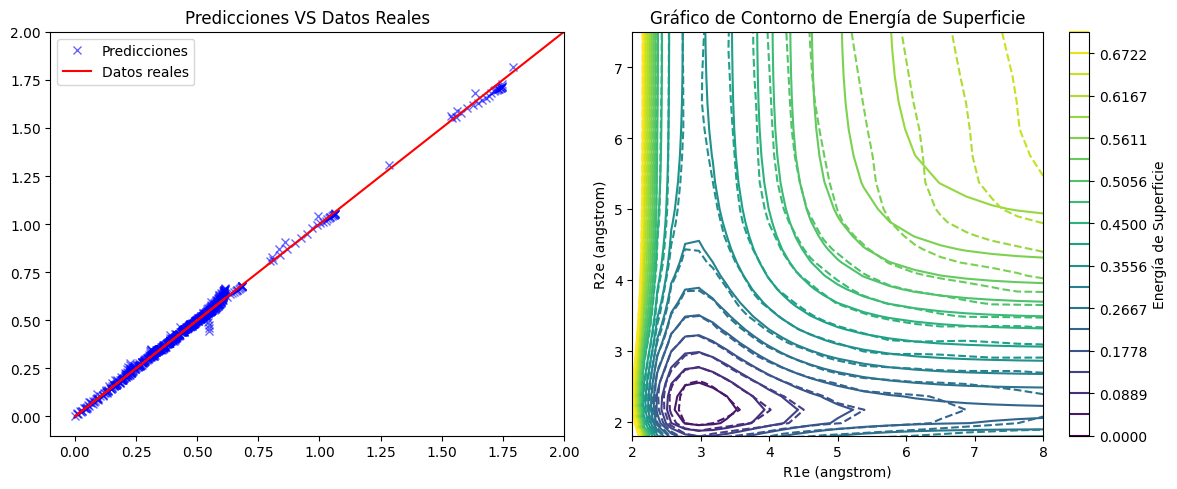

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))  # 1 fila, 2 columnas

# --- Primer gráfico (Predicciones vs Datos reales) ---
ax1.plot(df['V'], df1['predicted'],'x', label="Predicciones", color='blue', alpha=0.6)
ax1.plot(df['V'], df['V'], color='red', label='Datos reales')
ax1.legend()
ax1.set_title("Predicciones VS Datos Reales")
ax1.axis([-0.1,2,-0.1,2])

# --- Segundo gráfico (Contorno Energía de Superficie) ---
v128 = np.load('TrainPREDS'+'_Lambda'+str(lamd)+'_Pts'+str(len(q2))+'.npy')
Ncontours = 20
R2e, R1e = np.meshgrid(q2, q1)
energia_superficie = np.vectorize(V)(R1e, R2e, np.pi)
energia_superficie1 =  v128[1,:].reshape(len(q2),len(q2))

level_min = 0.0
level_max = 0.7
levels0 = np.concatenate((np.linspace(level_min,0.4,Ncontours-10), np.linspace(0.45,level_max,10)))

ctreal = ax2.contour(R1e, R2e, energia_superficie, levels0, vmin=level_min, vmax=level_max)
ctpred = ax2.contour(R1e, R2e, energia_superficie1, levels0, vmin=level_min, vmax=level_max, linestyles='dashed')

fig.colorbar(ctreal, ax=ax2, label='Energía de Superficie')

ax2.set_xlabel('R1e (angstrom)')
ax2.set_ylabel('R2e (angstrom)')
ax2.set_title('Gráfico de Contorno de Energía de Superficie')
ax2.axis([2.0,8.0,1.8,7.5])

plt.tight_layout()
plt.show()
